# Creating the dataset from:
    - donateacry-corpus: https://github.com/gveres/donateacry-corpus/
    - ESC-50: https://github.com/karolpiczak/ESC-50

## need to eliminate the baby crying from the negatives

In [1]:
# !pip install matplotlib
# !pip install librosa

# donateacry cleaning and testing

In [ ]:
def rewrite_file_params(filepath):
    pass

In [5]:
import os
import IPython.display as ipd

import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import pandas as pd  
import librosa as lb 
import librosa.display 
import wave

%matplotlib inline

In [8]:
cry_data_path = "./data/donateacry_cleaned"
cry_categories = os.listdir(cry_data_path)
cry_categories = [cat for cat in cry_categories if cat != 'README.md']
cry_categories

['discomfort', 'tired', 'belly_pain', 'burping', 'hungry']

In [9]:
cry_testing_file = cry_data_path + "/" + cry_categories[0] + "/" + os.listdir(cry_data_path + "/" + cry_categories[0])[0]
cry_testing_file

'./data/donateacry_cleaned/discomfort/10A40438-09AA-4A21-83B4-8119F03F7A11-1430925142-1.0-f-26-dc.wav'

In [10]:

ipd.Audio(cry_testing_file)

In [11]:
sample_rate, audio = wavfile.read(cry_testing_file)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 8000Hz
Audio duration: 7.0s


In [12]:
with wave.open(cry_testing_file, 'rb') as wf:
    print(wf.getnchannels())
    print(wf.getframerate())


1
8000


## go through the directory and put all files in one dataframe

In [13]:
# cries = pd.DataFrame(columns = ['filename', 'category'])
cries_list = np.array([[fname,category] for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
cries = pd.DataFrame(cries_list, columns = ['filename', 'classification'])

In [14]:
cries.head()

,filename,classification
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,discomfort
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,discomfort
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,discomfort
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,discomfort
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,discomfort


In [15]:
print(set(cries['classification']))

{'hungry', 'belly_pain', 'burping', 'tired', 'discomfort'}


# ESC50 cleaning

In [11]:
print(len(metadata))
print(len(clean_esc50))

2000
1960


In [16]:
csvPath = "./data/esc_50/meta/esc50.csv" 
metadata = pd.read_csv(csvPath) 
# metadata.head()
clean_esc50 = metadata[metadata['category'] != "crying_baby"]
clean_esc50.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## put esc50 common format (filename | classification)

In [17]:
esc50_formatted = clean_esc50.filter(['filename'],axis=1)
esc50_formatted.insert(1,'classification','negative')
esc50_formatted.head()

,filename,classification
0,1-100032-A-0.wav,negative
1,1-100038-A-14.wav,negative
2,1-100210-A-36.wav,negative
3,1-100210-B-36.wav,negative
4,1-101296-A-19.wav,negative


In [65]:
print(esc50_formatted)

               filename classification
0      1-100032-A-0.wav       negative
1     1-100038-A-14.wav       negative
2     1-100210-A-36.wav       negative
3     1-100210-B-36.wav       negative
4     1-101296-A-19.wav       negative
...                 ...            ...
1995   5-263831-B-6.wav       negative
1996  5-263902-A-36.wav       negative
1997   5-51149-A-25.wav       negative
1998    5-61635-A-8.wav       negative
1999     5-9032-A-0.wav       negative

[1960 rows x 2 columns]


In [18]:
esc_audio_path = "./data/esc_50/audio"
esctestfile = esc50_formatted['filename'][0]

In [19]:
with wave.open(esc_audio_path + "/" + esctestfile, 'rb') as wf:
    print(wf.getnchannels())
    print(wf.getframerate())


1
44100


# Messing with file loading

## MFCCs

In [20]:
def loadfile(fname):
    with wave.open(fname, 'rb') as wf:
        # print(wf.getnchannels())
        # print(wf.getframerate())
        print(wf.getparams())
        frames = wf.readframes(wf.getnframes())
        print(len(frames))
        # print(frames)
        audio_data = frames
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        return audio_array
        
def extract_mfccs(audio_file_path):
    n_mfcc = 10
    audio_array = loadfile(audio_file_path)
    mfccs = librosa.feature.mfcc(y=audio_array, 
                              sr=8000, n_mfcc=10,dtype=np.float32)
    # y, sr = librosa.load(audio_file_path)
    # mfccs = librosa.feature.mfcc(y=y, sr=8000, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

## cries

In [21]:
# List of audio file paths
cry_data_path = "./data/donateacry_cleaned"
cry_audio_files = np.array([f"{cry_data_path}/{category}/{fname}" for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 

# Initialize an empty list to store the MFCC vectors
cry_mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in cry_audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    cry_mfcc_vectors.append(mfcc_vector)

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=56000, comptype='NONE', compname='not compressed')
112000


ParameterError: Audio buffer is not finite everywhere

In [127]:
n_mfcc = 10
cries_mfcc_df = pd.DataFrame(data=cry_mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])

cries_mfcc_df.head()


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,2056.950928,-49.855419,-57.218704,-8.021647,-14.154765,2.169937,4.439253,-8.421792,-8.778833,6.802444
1,1919.295410,-92.935158,-16.060190,5.160862,-15.703839,-5.354736,1.927676,11.332192,-10.926098,-8.763183
2,1942.199341,51.696877,-35.350052,-7.471813,-6.911423,-16.008396,-18.528109,-19.207064,-27.817423,-25.715279
3,2011.373169,-47.088249,-60.068417,-10.464641,-12.936261,1.513001,8.410989,2.301756,-16.444115,-9.253676
4,1802.441162,7.087576,-33.321789,-8.380128,-21.079954,-12.120520,-32.476292,-4.764588,-17.324795,-18.150364


In [128]:
print(cries_mfcc_df.size)
print(len(cry_audio_files))

4570
457


## negatives

In [104]:
esc50_formatted.to_csv('intermediate.csv', index=False)
esc50_formatted = pd.read_csv('intermediate.csv')

In [105]:
# List of audio file paths
neg_data_path = "./data/esc_50/audio"
neg_audio_files = np.array([f"{neg_data_path}/{fname}" for fname in esc50_formatted['filename']]) 

# Initialize an empty list to store the MFCC vectors
neg_mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in neg_audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    neg_mfcc_vectors.append(mfcc_vector)

In [106]:
n_mfcc = 10
neg_mfcc_df = pd.DataFrame(data=neg_mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])

neg_mfcc_df.tail()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
1955,729.234131,161.647766,30.756815,24.977142,-1.410881,-1.191111,1.976924,-2.026938,1.675846,-2.088073
1956,942.969604,149.435165,-98.246445,90.575569,-48.954140,50.591267,-19.221737,5.035063,13.747256,-21.982349
1957,702.595398,86.047966,7.688797,25.062363,9.981625,10.810649,5.836665,8.459169,4.857493,5.734694
1958,832.148071,132.961914,4.196231,51.854862,-37.962681,22.720526,-8.419871,14.072458,-15.192708,-5.295647
1959,580.375427,44.388229,-6.017336,-7.052705,-6.423955,-2.268004,0.653581,-3.871778,-3.290145,-2.417947


In [107]:
print(len(esc50_formatted))
print(len(neg_mfcc_df))

1960
1960


In [108]:
print(esc50_formatted)

               filename classification
0      1-100032-A-0.wav       negative
1     1-100038-A-14.wav       negative
2     1-100210-A-36.wav       negative
3     1-100210-B-36.wav       negative
4     1-101296-A-19.wav       negative
...                 ...            ...
1955   5-263831-B-6.wav       negative
1956  5-263902-A-36.wav       negative
1957   5-51149-A-25.wav       negative
1958    5-61635-A-8.wav       negative
1959     5-9032-A-0.wav       negative

[1960 rows x 2 columns]


In [109]:
neg_dataset = pd.concat([esc50_formatted,neg_mfcc_df],axis=1)

In [110]:
neg_dataset.tail()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
1955,5-263831-B-6.wav,negative,729.234131,161.647766,30.756815,24.977142,-1.410881,-1.191111,1.976924,-2.026938,1.675846,-2.088073
1956,5-263902-A-36.wav,negative,942.969604,149.435165,-98.246445,90.575569,-48.954140,50.591267,-19.221737,5.035063,13.747256,-21.982349
1957,5-51149-A-25.wav,negative,702.595398,86.047966,7.688797,25.062363,9.981625,10.810649,5.836665,8.459169,4.857493,5.734694
1958,5-61635-A-8.wav,negative,832.148071,132.961914,4.196231,51.854862,-37.962681,22.720526,-8.419871,14.072458,-15.192708,-5.295647
1959,5-9032-A-0.wav,negative,580.375427,44.388229,-6.017336,-7.052705,-6.423955,-2.268004,0.653581,-3.871778,-3.290145,-2.417947


# Concatenate dataframes

## Cries classification

In [129]:
cries_dataset = pd.concat([cries,cries_mfcc_df], axis=1)
cries_dataset.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,discomfort,2056.950928,-49.855419,-57.218704,-8.021647,-14.154765,2.169937,4.439253,-8.421792,-8.778833,6.802444
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,discomfort,1919.295410,-92.935158,-16.060190,5.160862,-15.703839,-5.354736,1.927676,11.332192,-10.926098,-8.763183
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,discomfort,1942.199341,51.696877,-35.350052,-7.471813,-6.911423,-16.008396,-18.528109,-19.207064,-27.817423,-25.715279
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,discomfort,2011.373169,-47.088249,-60.068417,-10.464641,-12.936261,1.513001,8.410989,2.301756,-16.444115,-9.253676
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,discomfort,1802.441162,7.087576,-33.321789,-8.380128,-21.079954,-12.120520,-32.476292,-4.764588,-17.324795,-18.150364


In [112]:
cries_dataset.to_csv('cries_classification.csv', index=False)

## Cry detection

In [113]:
neg_dataset = pd.concat([esc50_formatted,neg_mfcc_df],axis=1)
pos_dataset = cries_dataset.assign(classification='positive')
pos_dataset.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,positive,929.014832,19.822575,-47.350857,-30.245201,-21.855499,-8.129131,-14.099008,-8.989732,-17.492725,-0.152560
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,positive,813.088928,-28.164577,-59.126396,-10.630727,-19.886158,18.044292,-23.957348,13.951138,-15.480292,-11.093403
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,positive,799.248718,106.592682,-2.445993,7.357971,-19.878782,2.573098,-10.899929,11.729693,-12.498252,3.451674
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,positive,890.449951,21.205910,-34.534603,-33.751324,-33.044239,5.839946,-20.564890,-2.141417,-11.258945,-2.273828
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,positive,660.755615,101.454803,-54.192043,11.089276,-4.415250,-16.562540,-9.532226,3.105078,-5.860729,-10.071422


In [114]:
detection_dataset = pd.concat([neg_dataset,pos_dataset])

In [115]:
detection_dataset.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-100032-A-0.wav,negative,494.830841,10.294344,1.111452,2.627594,-1.697798,-2.135711,-1.150459,-1.397518,-1.624161,-0.958297
1,1-100038-A-14.wav,negative,803.808167,155.104919,-60.574547,6.048802,-9.613963,-8.536694,-7.695093,-3.446557,15.709990,3.629604
2,1-100210-A-36.wav,negative,1013.069580,123.483681,-36.936245,35.574203,-19.142288,34.406319,-10.934359,24.084787,-29.679832,11.153445
3,1-100210-B-36.wav,negative,1010.730286,127.907745,-42.541599,42.149696,-21.280687,32.851433,-9.566648,20.871023,-25.734701,9.449923
4,1-101296-A-19.wav,negative,556.475464,113.051788,3.755488,41.497749,16.722778,36.695667,8.586819,21.837311,2.769912,10.127470


In [116]:
detection_dataset.tail()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
452,8f5c01dc-6826-4076-a831-027ad61afdaf-143587350...,positive,801.491943,-28.927538,-46.037895,-8.618154,-10.506639,-15.690027,0.223281,-4.746837,-4.736784,5.391144
453,40a4c760-facf-4911-b0a6-22eccc3ab18d-143047771...,positive,990.827820,-27.010868,7.823496,-9.228694,-11.188974,-1.651927,-9.149456,-16.174717,-13.439293,-3.966693
454,F24DE44B-762C-4149-AC92-96A5E57ED118-143081693...,positive,795.529602,32.426613,-17.285643,-21.758980,-35.890095,-25.757706,-7.051079,-20.294167,-8.809352,4.736472
455,9aa8bac5-eeb9-4f19-a4bf-7c439e87364b-143074538...,positive,767.303101,30.718958,-37.727489,-16.558054,-42.972973,18.793978,-9.468043,-19.045712,-10.654701,-13.975971
456,aaa57dbd-7b88-454a-963e-6faa2f4ed4e7-143691022...,positive,561.621826,23.139704,1.073212,7.567330,-0.572748,-2.562028,-13.519232,-5.332527,-4.828667,-0.546336


In [117]:
detection_dataset.to_csv('cry_detection.csv', index=False)

## cries visualization

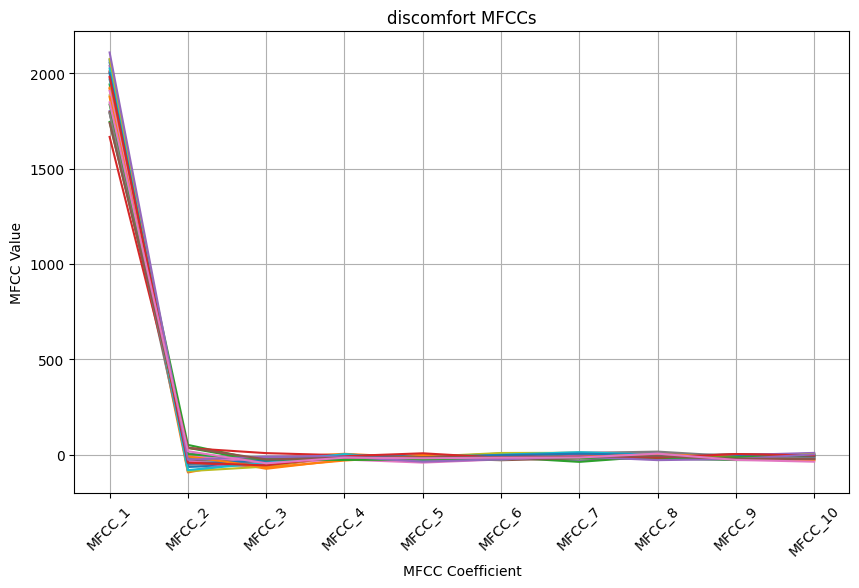

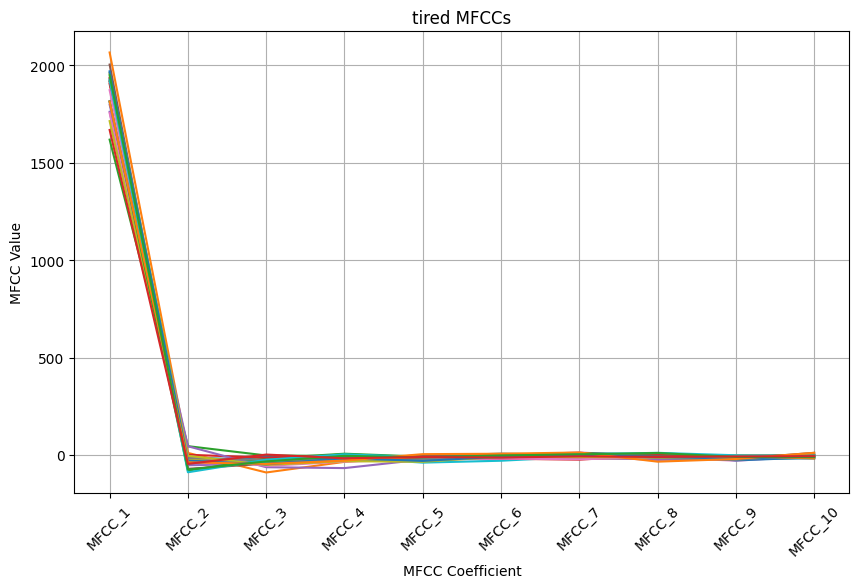

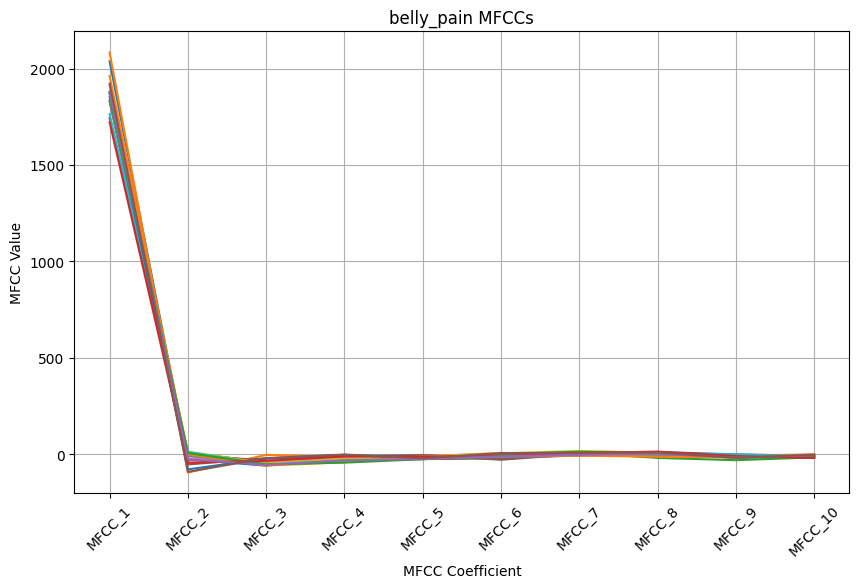

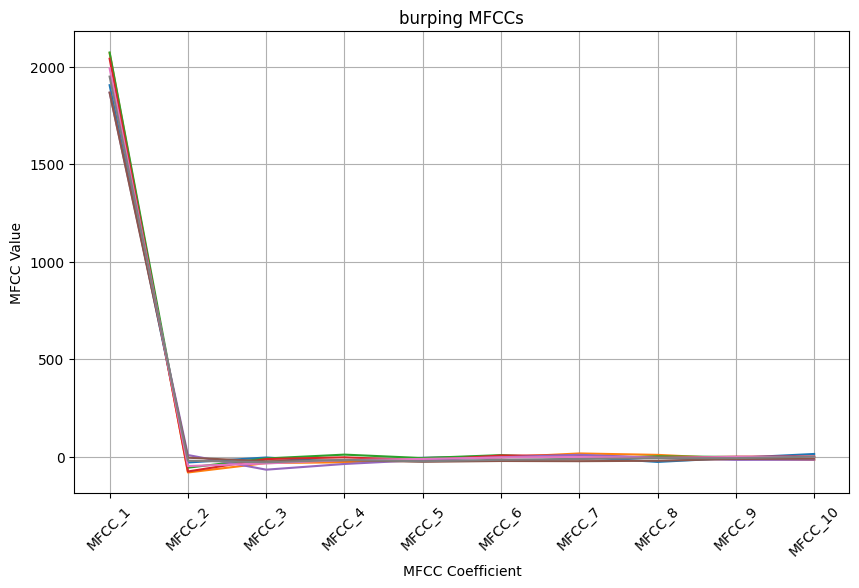

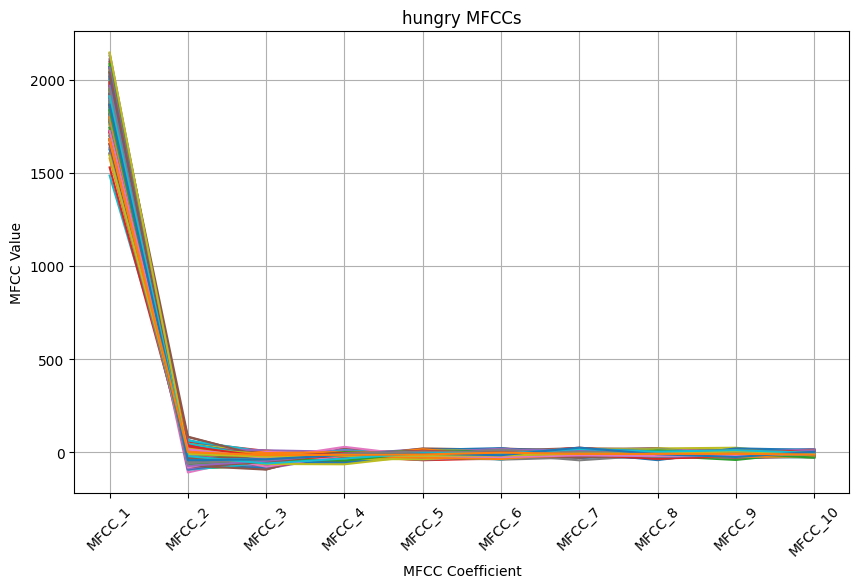

In [130]:
for i, category in enumerate(cry_categories):
    category_cries = cries_dataset.loc[cries_dataset['classification'] == category]
    plt.figure(figsize=(10, 6))
    for index, row in category_cries.iterrows():
        plt.plot(category_cries.columns[2:], row[2:], label=row['filename'])  # Assuming 'Filename' is the column with filenames

    plt.xlabel('MFCC Coefficient')
    plt.ylabel('MFCC Value')
    plt.title(f"{category} MFCCs")
    # plt.legend()
    plt.grid()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


# Stich Esc50 cries for testing

In [119]:
esccsvPath = "./data/esc_50/meta/esc50.csv" 
escmeta = pd.read_csv(esccsvPath) 
# metadata.head()
cry_esc50 = escmeta[escmeta['category'] == "crying_baby"].sample(3)
cry_esc50.head()

,filename,fold,target,category,esc10,src_file,take
1730,5-198411-C-20.wav,5,20,crying_baby,True,198411,C
1729,5-198411-B-20.wav,5,20,crying_baby,True,198411,B
577,2-151079-A-20.wav,2,20,crying_baby,True,151079,A


In [120]:
rando_esc50 = escmeta[escmeta['category'] != "crying_baby"].sample(5)
rando_esc50.head()

,filename,fold,target,category,esc10,src_file,take
867,3-118972-B-41.wav,3,41,chainsaw,True,118972,B
924,3-136451-A-45.wav,3,45,train,False,136451,A
223,1-47250-A-41.wav,1,41,chainsaw,True,47250,A
1014,3-152020-C-36.wav,3,36,vacuum_cleaner,False,152020,C
543,2-130245-A-34.wav,2,34,can_opening,False,130245,A


In [121]:
test_audio_df = pd.concat([rando_esc50,cry_esc50], axis=0).sample(frac=1).reset_index(drop=True)

In [122]:
test_audio_df.head()

,filename,fold,target,category,esc10,src_file,take
0,5-198411-B-20.wav,5,20,crying_baby,True,198411,B
1,3-136451-A-45.wav,3,45,train,False,136451,A
2,2-151079-A-20.wav,2,20,crying_baby,True,151079,A
3,3-152020-C-36.wav,3,36,vacuum_cleaner,False,152020,C
4,3-118972-B-41.wav,3,41,chainsaw,True,118972,B


In [123]:
files = np.array(test_audio_df['filename'])
print(files)

['5-198411-B-20.wav' '3-136451-A-45.wav' '2-151079-A-20.wav'
 '3-152020-C-36.wav' '3-118972-B-41.wav' '1-47250-A-41.wav'
 '2-130245-A-34.wav' '5-198411-C-20.wav']


In [124]:
escfilepath = "./data/esc_50/audio"

In [13]:
import wave

outfile = "sounds.wav"

data= []
for infile in files:
    w = wave.open(f"{escfilepath}/{infile}", 'rb')
    data.append( [w.getparams(), w.readframes(w.getnframes())] )
    w.close()
    
output = wave.open(outfile, 'wb')
output.setparams(data[0][0])
for i in range(len(data)):
    output.writeframes(data[i][1])
output.close()

In [50]:
doncsvPath = "cries_classification.csv"

In [51]:
rando_donateacry = pd.read_csv(doncsvPath).sample(3)
rando_donateacry_files = np.array(rando_donateacry['filename'])
rando_donateacry_paths = np.array(rando_donateacry['classification'])

In [52]:
rando_donateacry.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
318,80f5ab0a-16c1-4738-9209-fbdae52ff769-143014063...,hungry,-393.86707,142.04478,-68.64886,-12.351719,23.418087,-32.944260,-16.072527,3.069805,-21.779276,-13.246329
61,d6cda191-4962-4308-9a36-46d5648a95ed-143115926...,belly_pain,-395.84424,148.65533,-110.64311,-13.160523,19.919676,-40.894672,9.511747,13.925347,-28.453740,0.005165
27,B2AABCE0-1F62-4B57-B58A-308959ABDFE7-143718875...,tired,-332.34800,151.82791,-66.24621,2.983669,26.656270,-33.877617,-6.559296,5.100831,-18.202547,-4.027008


In [53]:
for i, file in enumerate(rando_donateacry_files):
    rando_donateacry_files[i] = f"./data/donateacry_cleaned/{rando_donateacry_paths[i]}/{file}"
print(rando_donateacry_files)

['./data/donateacry_cleaned/hungry/80f5ab0a-16c1-4738-9209-fbdae52ff769-1430140636917-1.7-f-04-hu.wav'
 './data/donateacry_cleaned/belly_pain/d6cda191-4962-4308-9a36-46d5648a95ed-1431159262344-1.7-m-04-bp.wav'
 './data/donateacry_cleaned/tired/B2AABCE0-1F62-4B57-B58A-308959ABDFE7-1437188751-1.1-m-26-ti.wav']


In [56]:
otherfiles = rando_donateacry_files
print(otherfiles)

['./data/donateacry_cleaned/hungry/80f5ab0a-16c1-4738-9209-fbdae52ff769-1430140636917-1.7-f-04-hu.wav'
 './data/donateacry_cleaned/belly_pain/d6cda191-4962-4308-9a36-46d5648a95ed-1431159262344-1.7-m-04-bp.wav'
 './data/donateacry_cleaned/tired/B2AABCE0-1F62-4B57-B58A-308959ABDFE7-1437188751-1.1-m-26-ti.wav']


In [46]:
otherfiles = np.array(rando_esc50['filename'])
for i, file in enumerate(otherfiles):
    otherfiles[i] = f"{escfilepath}/{file}"
otherfiles = np.append(otherfiles,rando_donateacry_files)
print(otherfiles)

['./data/esc_50/audio/5-257642-A-39.wav'
 './data/esc_50/audio/4-197454-A-28.wav'
 './data/esc_50/audio/4-187769-B-14.wav'
 './data/esc_50/audio/4-208021-A-1.wav'
 './data/esc_50/audio/3-172179-A-31.wav'
 './data/donateacry_cleaned/hungry/89964233-cbdb-4f34-a819-5f4b5ce3f5f5-1430049868816-1.7-f-04-hu.wav'
 './data/donateacry_cleaned/hungry/1445575b-80ad-477b-8e48-36194cac728e-1430244987914-1.7-f-48-hu.wav'
 './data/donateacry_cleaned/hungry/F24DE44B-762C-4149-AC92-96A5E57ED118-1430816936-1.0-m-04-hu.wav']


In [57]:
import wave

outfile = "othersounds.wav"

data= []
for infile in otherfiles:
    w = wave.open(f"{infile}", 'rb')
    data.append( [w.getparams(), w.readframes(w.getnframes())] )
    w.close()
    
output = wave.open(outfile, 'wb')
output.setparams(data[0][0])
for i in range(len(data)):
    output.writeframes(data[i][1])
output.close()